
# Package Importation



In [ ]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers import add, Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization, RepeatVector, Reshape, Activation
from keras.models import Model
np.random.seed(1)
import tensorflow as tf

# Attach to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
InputPath="/content/drive/MyDrive/LOLdataset/our485/high"

# Noise Addition

In [ ]:
def addNoise(image):
    noiseAddedImage = np.copy(image)


    num_pixels = int(np.ceil(image.size * 0.5))
    coords = [np.random.randint(0, s, num_pixels) for s in image.shape]
    noiseAddedImage[tuple(coords)] = 1


    num_pixels_remaining = int(np.ceil(image.size * (1.0 - 0.5)))
    coords = [np.random.randint(0, s, num_pixels_remaining) for s in image.shape]
    noiseAddedImage[tuple(coords)] = 1

    return noiseAddedImage


# Original Image and Noise Image

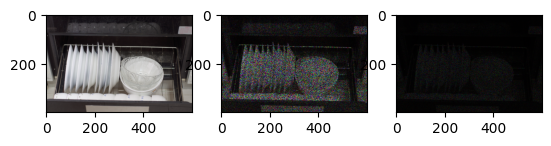

In [ ]:
img = cv.imread(InputPath+"/100.png")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
l = img.max()
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
Noise = addNoise(img)
plt.imshow(Noise)
plt.subplot(1,3,3)
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
hsv[...,2] = hsv[...,2]*0.2
img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
Noise2 = addNoise(img1)
plt.imshow(Noise2)

# Data Preprocessing

In [ ]:
from tqdm import tqdm
HighPath = "/content/drive/MyDrive/LOLdataset/our485/high"

def PreProcessData(ImagePath):
    X_=[]
    y_=[]
    count=0
    for imageName in tqdm(os.listdir(HighPath)):
        count=count+1
        low_img = cv.imread(HighPath + "/" + imageName)
        if low_img is None:
                continue
        low_img = cv.cvtColor(low_img, cv.COLOR_BGR2RGB)
        low_img = cv.resize(low_img,(500,500))
        hsv = cv.cvtColor(low_img, cv.COLOR_BGR2HSV)
        hsv[...,2] = hsv[...,2]*0.2
        img_1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
        Noisey_img = addNoise(img_1)
        X_.append(Noisey_img)
        y_.append(low_img)
    X_ = np.array(X_)
    y_ = np.array(y_)

    return X_,y_

In [ ]:
X_,y_ = PreProcessData(InputPath)

100%|██████████| 486/486 [00:33<00:00, 14.52it/s]


# Model Creation

In [ ]:
K.clear_session()

def InstantiateModel(in_):

    model_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_1)
    model_1 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_1)

    model_2 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_2 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)

    model_2_0 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)

    model_add = add([model_1,model_2,model_2_0])

    model_3 = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_3)
    model_3 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3)

    model_3_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3_1 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3_1)

    model_3_2 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add)

    model_add_2 = add([model_3_1,model_3_2,model_3])

    model_4 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_2)
    model_4_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add)

    model_add_3 = add([model_4_1,model_add_2,model_4])

    model_5 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_3)
    model_5 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add_3)

    model_5 = Conv2D(3,(3,3), activation='relu',padding='same',strides=1)(model_5)

    return model_5


In [ ]:
Input_Sample = Input(shape=(500, 500,3))
Output_ = InstantiateModel(Input_Sample)
Model_Enhancer = Model(inputs=Input_Sample, outputs=Output_)
Model_Enhancer.compile(optimizer="adam", loss='mean_squared_error')
Model_Enhancer.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500, 500, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 500, 500, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 500, 500, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 500, 500, 32)         4640      ['conv2d[0][0]']              
                                                                                              

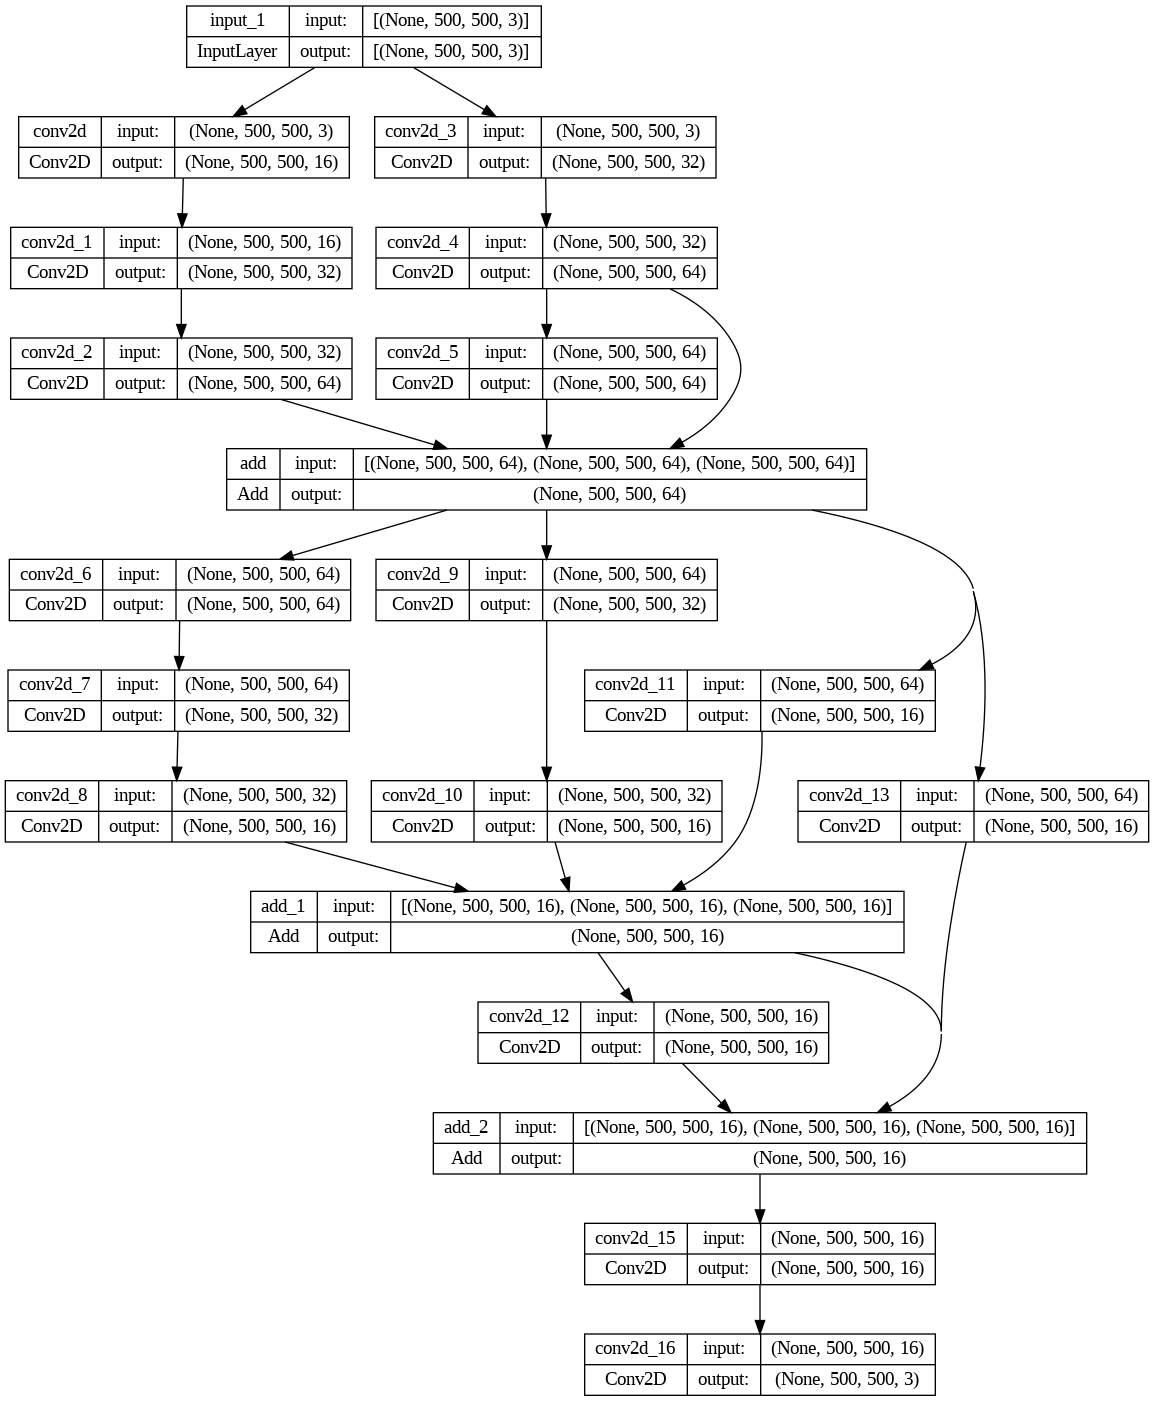

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(Model_Enhancer, to_file='model_.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_.png')


# Training

Epoch 1/100
3/3 [==============================] - 0s 143ms/step - loss: 204.1611 - val_loss: 118.7834
Epoch 2/100
3/3 [==============================] - 0s 134ms/step - loss: 214.6444 - val_loss: 318.5459
Epoch 3/100
3/3 [==============================] - 0s 118ms/step - loss: 137.9053 - val_loss: 57.8603
Epoch 4/100
3/3 [==============================] - 0s 120ms/step - loss: 177.3599 - val_loss: 107.9792
Epoch 5/100
3/3 [==============================] - 0s 122ms/step - loss: 102.7419 - val_loss: 209.1552
Epoch 6/100
3/3 [==============================] - 0s 119ms/step - loss: 171.1061 - val_loss: 106.7336
Epoch 7/100
3/3 [==============================] - 0s 121ms/step - loss: 198.4453 - val_loss: 338.2771
Epoch 8/100
3/3 [==============================] - 0s 122ms/step - loss: 333.3146 - val_loss: 194.0276
Epoch 9/100
3/3 [==============================] - 0s 124ms/step - loss: 216.3588 - val_loss: 526.6583
Epoch 10/100
3/3 [==============================] - 0s 121ms/step - loss: 

3/3 [==============================] - 0s 141ms/step - loss: 143.8886
Epoch 21/100
3/3 [==============================] - 0s 113ms/step - loss: 100.3845
Epoch 22/100
3/3 [==============================] - 0s 109ms/step - loss: 309.7162
Epoch 23/100
3/3 [==============================] - 0s 113ms/step - loss: 204.7646
Epoch 24/100
3/3 [==============================] - 0s 111ms/step - loss: 200.4348
Epoch 25/100
3/3 [==============================] - 0s 110ms/step - loss: 146.7503
Epoch 26/100
3/3 [==============================] - 0s 108ms/step - loss: 131.8932
Epoch 27/100
3/3 [==============================] - 0s 111ms/step - loss: 293.2291
Epoch 28/100
3/3 [==============================] - 0s 110ms/step - loss: 271.8914
Epoch 29/100
3/3 [==============================] - 0s 107ms/step - loss: 154.0343
Epoch 30/100
3/3 [==============================] - 0s 110ms/step - loss: 476.7004
Epoch 31/100
3/3 [==============================] - 0s 108ms/step - loss: 220.0324
Epoch 32/100
3/3 

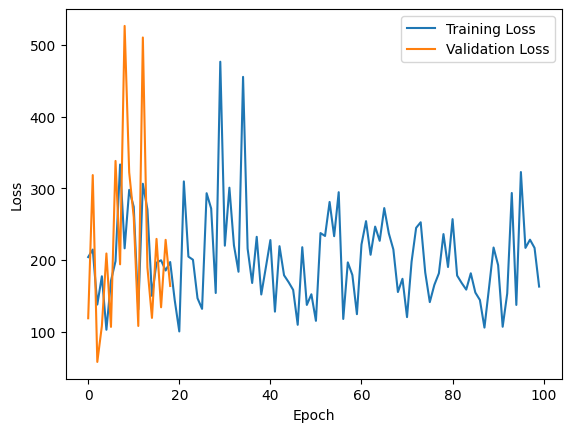

In [ ]:
import pickle
def GenerateInputs(X,y):
    for i in range(len(X)):
        X_input = X[i].reshape(1,500,500,3)
        y_input = y[i].reshape(1,500,500,3)
        yield (X_input,y_input)

his = Model_Enhancer.fit_generator(GenerateInputs(X_,y_),epochs=100,verbose=1,steps_per_epoch=3,shuffle=True)

pickle.dump(his.history, open("his.pickle", 'wb'))

#For validation
'''import pickle
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, random_state=42)

def GenerateInputs(X, y):
    for i in range(len(X)):
        X_input = X[i].reshape(1, 500, 500, 3)
        y_input = y[i].reshape(1, 500, 500, 3)
        yield (X_input, y_input)

# Assuming Model_Enhancer is already defined

epochs = 100


# Train the model
his = Model_Enhancer.fit(
    GenerateInputs(X_train, y_train),
    epochs=epochs,
    verbose=1,
    validation_data=GenerateInputs(X_val, y_val),
    steps_per_epoch=3,
    validation_steps=1,
    shuffle=True
)

# Save the training history
with open("his.pickle", 'wb') as f:
    pickle.dump(his.history, f)

# Plot training and validation loss
plt.plot(his.history['loss'], label='Training Loss')
plt.plot(his.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()'''

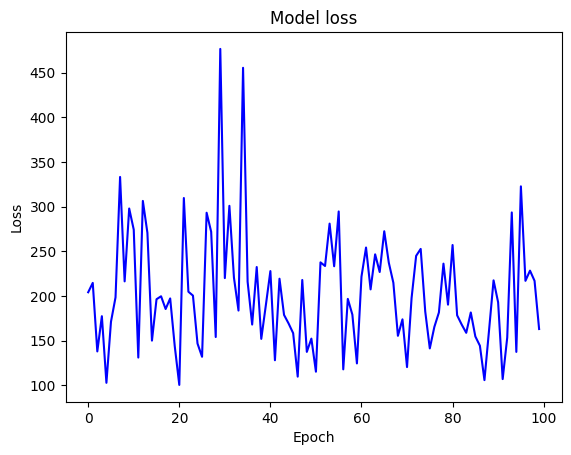

In [ ]:
plt.plot(his.history['loss'],'b')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


In [ ]:
TestPath="/content/drive/MyDrive/LOLdataset/eval15/high"

In [ ]:
def ExtractTestInput(ImagePath):
    img = cv.imread(ImagePath)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_ = cv.resize(img,(500,500))
    hsv = cv.cvtColor(img_, cv.COLOR_BGR2HSV)
    hsv[...,2] = hsv[...,2]*0.2
    img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    Noise = addNoise(img1)
    Noise = Noise.reshape(1,500,500,3)
    return Noise

# Inference

1/1 [==============================] - 0s 20ms/step


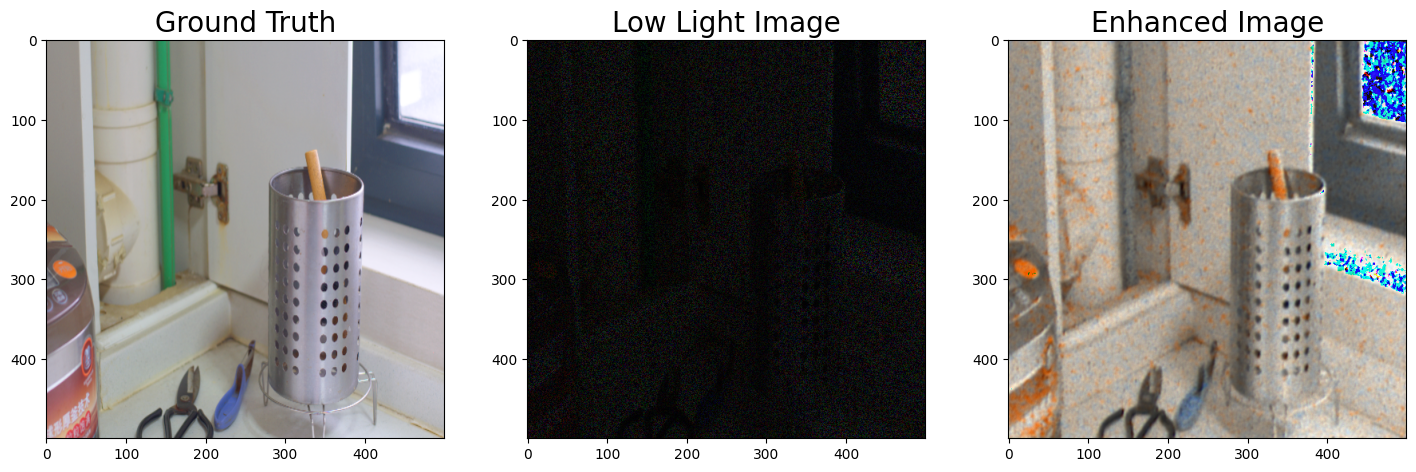

In [ ]:
ImagePath=TestPath+"/111.png"

plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(ImagePath)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(ImagePath)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Enhancer.predict(image_for_test)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)


# Accuracy Metrics

  0%|          | 0/15 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


<ipython-input-16-819fee6876e6>:16: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value = psnr(original, enhanced)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)
  7%|▋         | 1/15 [00:00<00:09,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 2/15 [00:01<00:06,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 3/15 [00:01<00:04,  2.67it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 4/15 [00:01<00:04,  2.22it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 5/15 [00:02<00:04,  2.04it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 6/15 [00:02<00:04,  2.23it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 7/15 [00:03<00:03,  2.07it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 8/15 [00:03<00:03,  1.87it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 9/15 [00:04<00:03,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 10/15 [00:05<00:03,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 11/15 [00:05<00:02,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 12/15 [00:06<00:01,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 13/15 [00:07<00:01,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 14/15 [00:07<00:00,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 15/15 [00:08<00:00,  1.83it/s]


Average PSNR: 20.30 dB
Average SSIM: 0.7176


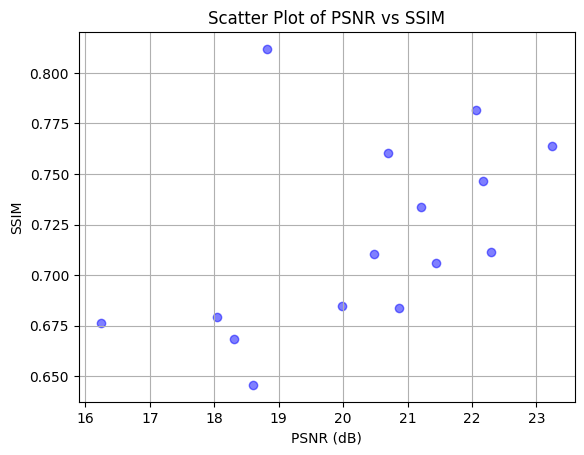

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

psnr_values = []
ssim_values = []

for imageName in tqdm(os.listdir(TestPath)):
  ImagePath = TestPath + "/" + imageName
  img_1 = cv.imread(ImagePath)
  img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
  original = cv.resize(img_1, (500, 500))
  image_for_test = ExtractTestInput(ImagePath)
  Prediction = Model_Enhancer.predict(image_for_test)
  enhanced = Prediction.reshape(500,500,3)

  psnr_value = psnr(original, enhanced)

  original_gray = cv.cvtColor(original, cv.COLOR_BGR2GRAY)
  enhanced_gray = cv.cvtColor(enhanced, cv.COLOR_BGR2GRAY)

  ssim_value, _ = ssim(original_gray, enhanced_gray, full=True)

  psnr_values.append(psnr_value)
  ssim_values.append(ssim_value)

avg_psnr = np.mean(psnr_values)
avg_ssim = np.mean(ssim_values)
print()
print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")

plt.scatter(psnr_values, ssim_values, color='blue', alpha=0.5)
plt.xlabel('PSNR (dB)')
plt.ylabel('SSIM')
plt.title('Scatter Plot of PSNR vs SSIM')
plt.grid(True)
plt.show()


#Real Life Low Light Images

1/1 [==============================] - 0s 18ms/step


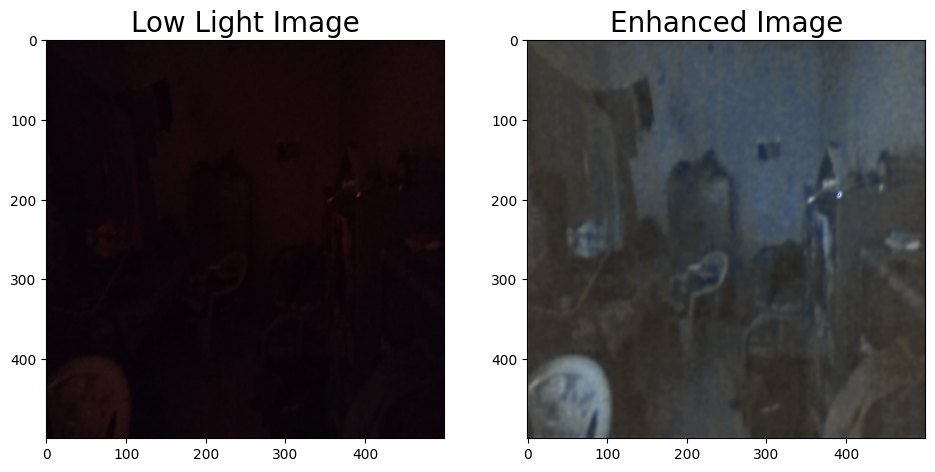

In [ ]:
impath = "/content/drive/MyDrive/LOLdataset/eval15/HR.jpg"

plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(impath)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
mimg = cv.imread(impath)
mimg = cv.resize(mimg, (500,500))
image_for_test = mimg.reshape(1,500,500,3)
Prediction = Model_Enhancer.predict(image_for_test)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)

1/1 [==============================] - 0s 19ms/step


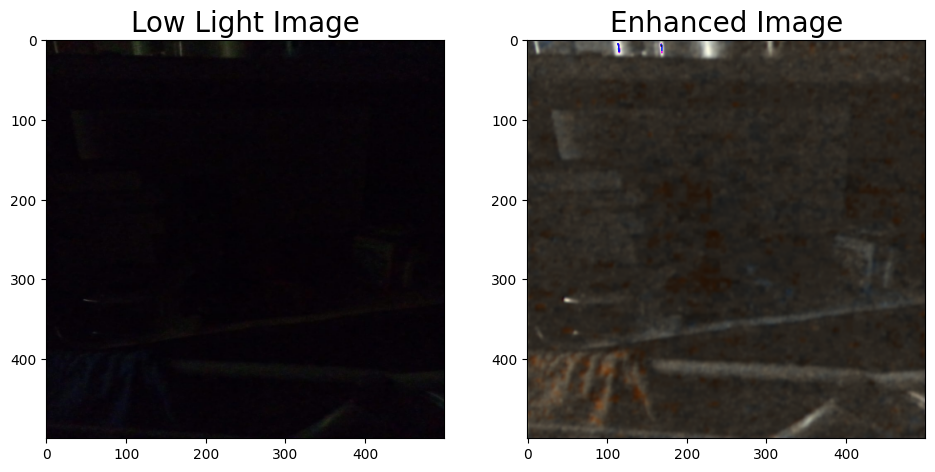

In [ ]:
impath = "/content/drive/MyDrive/LOLdataset/eval15/HR3.jpg"

plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(impath)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
mimg = cv.imread(impath)
mimg = cv.resize(mimg, (500,500))
image_for_test = mimg.reshape(1,500,500,3)
Prediction = Model_Enhancer.predict(image_for_test)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)

1/1 [==============================] - 0s 20ms/step


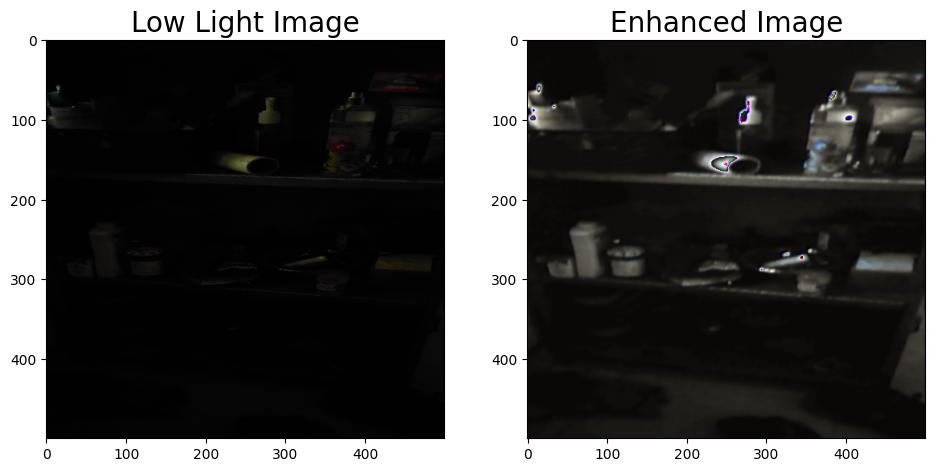

In [ ]:
impath = "/content/drive/MyDrive/LOLdataset/eval15/AR2.jpg"

plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(impath)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
mimg = cv.imread(impath)
mimg = cv.resize(mimg, (500,500))
image_for_test = mimg.reshape(1,500,500,3)
Prediction = Model_Enhancer.predict(image_for_test)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)

1/1 [==============================] - 0s 19ms/step


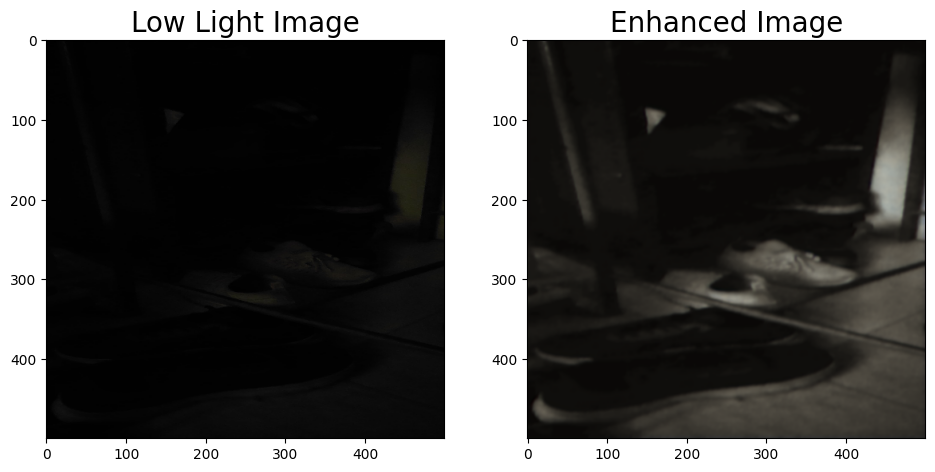

In [ ]:
impath = "/content/drive/MyDrive/LOLdataset/eval15/AR3.jpg"

plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(impath)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
mimg = cv.imread(impath)
mimg = cv.resize(mimg, (500,500))
image_for_test = mimg.reshape(1,500,500,3)
Prediction = Model_Enhancer.predict(image_for_test)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)

1/1 [==============================] - 0s 18ms/step


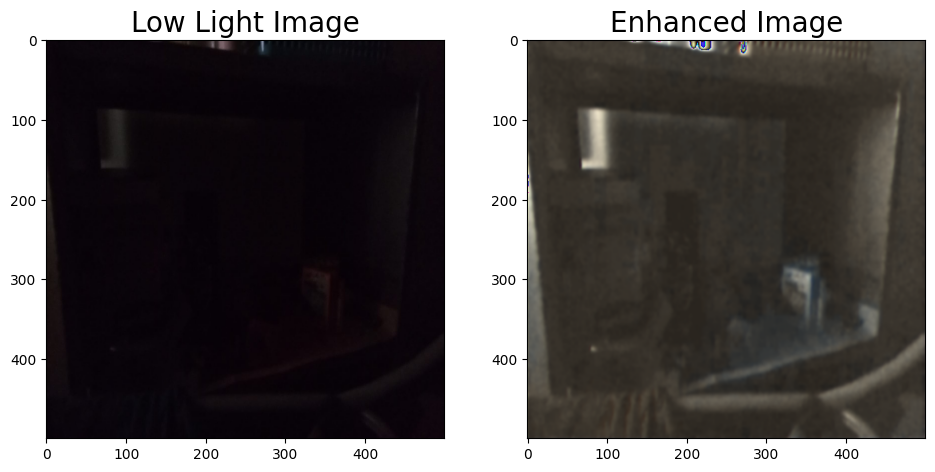

In [ ]:
impath = "/content/drive/MyDrive/LOLdataset/eval15/HC.jpg"

plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(impath)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
mimg = cv.imread(impath)
mimg = cv.resize(mimg, (500,500))
image_for_test = mimg.reshape(1,500,500,3)
Prediction = Model_Enhancer.predict(image_for_test)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)

1/1 [==============================] - 0s 19ms/step


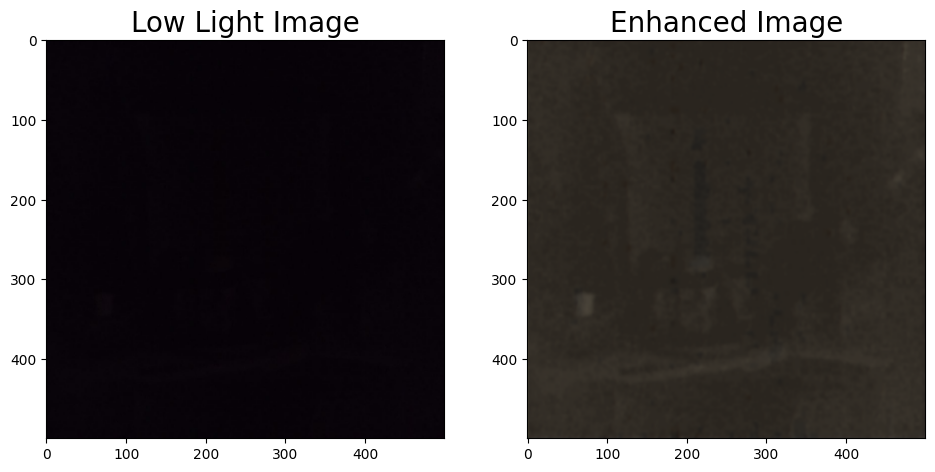

In [ ]:
impath = "/content/drive/MyDrive/LOLdataset/eval15/HC2.jpg"

plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(impath)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
mimg = cv.imread(impath)
mimg = cv.resize(mimg, (500,500))
image_for_test = mimg.reshape(1,500,500,3)
Prediction = Model_Enhancer.predict(image_for_test)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)